<a href="https://colab.research.google.com/github/yonatansverdlov/E-GenNet/blob/master/k_chains_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Disseminating geometric data: $k$-chains
Context:
In geometric graph neural networks (GNNs), the transmission of geometric data, like the relative positioning of local neighborhoods, occurs through the aggregation of features across multiple layers within fixed-dimensional spaces. Ideally, an architecture capable of operating across any number of layers would perfectly transmit geometric data without any loss. However, in practice, stacking geometric GNN layers can introduce distortions or result in the loss of information from distant nodes.

Experimental Setup:
To investigate the practical implications of depth in transmitting geometric information beyond local neighborhoods, we examine $k$-chain geometric graphs, a concept extending from examples discussed in Schütt et al., 2021. Each $k$-chain consists of $k+2$ nodes, with $k$ nodes arranged linearly and distinguished by the orientation of the $2$ endpoints. Consequently, $k$-chain graphs are $(\lfloor \frac{k}{2} \rfloor + 1)$-hop distinguishable, and theoretically, $(\lfloor \frac{k}{2} \rfloor + 1)$ iterations of geometric GNNs should suffice for their discrimination. Within this study, we train equivariant and invariant geometric GNNs, increasing the number of layers, to differentiate $k$-chains.

Additionally, we explore the impact of power graphs in scenarios where I-GGNNs are unable to distinguish between graphs. Specifically, we examine pairs of graphs depicted in the figure. In Pair A, theoretically, there is insufficient information to distinguish between $G_{1}$ and $G_{2}$, but there is adequate information in $G_{1}^{2}$ and $G_{2}^{2}$. In Pair B, theoretically, there is insufficient information to distinguish between $(G_{1}, G_{2})$ and $(G_{1}^{2}, G_{2}^{2})$, but there is adequate information in $(G_{1}^{3}, G_{2}^{3})$.

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
# We expact the k_chain_exps directory to be in that place.

!git clone https://github.com/yonatansverdlov/E-GenNet
sys.path.append('/content/E-GenNet/k_chain_exps')


Mounted at /content/drive
Cloning into 'E-GenNet'...
remote: Enumerating objects: 407, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 407 (delta 36), reused 36 (delta 15), pack-reused 331
Receiving objects: 100% (407/407), 1.58 MiB | 5.22 MiB/s, done.
Resolving deltas: 100% (213/213), done.


# Install Packages.

In [2]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric
!pip install e3nn


Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 63.2 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 50.8 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 40.2 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12

# Installation

# Imports

In [3]:
%load_ext autoreload
%autoreload 2

import sys

import torch
import torch_geometric
from torch_geometric.data import Data
import torch_geometric.loader as loader
from torch_geometric.utils import to_undirected
import e3nn
from functools import partial
import numpy as np

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))
print("e3nn version {}".format(e3nn.__version__))
from models.schnet import SchNetModel
from models.dimenet import DimeNetPPModel
from models.spherenet import SphereNetModel
from models.egnn import EGNNModel
from experiments.utils.plot_utils import plot_2d, plot_3d
from experiments.utils.data import create_kchains,create_pairA,create_pairB
from experiments.utils.train_utils import run_experiment
from models.schnet import SchNetModel
from models.dimenet import DimeNetPPModel
from models.spherenet import SphereNetModel
from models.egnn import EGNNModel
from models.gvpgnn import GVPGNNModel
from models.tfn import TFNModel
from models.mace import MACEModel
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version 2.3.0+cu121
PyG version 2.5.3
e3nn version 0.5.1
Using device: cuda


# Propogating geometric information: $k$-chains
In the first set of experiments we test the original $k$-chains for  $k$=4. Our aim is to examine short dependences of several models.
For that we run the desired model with increasing number of blocks and report the results.


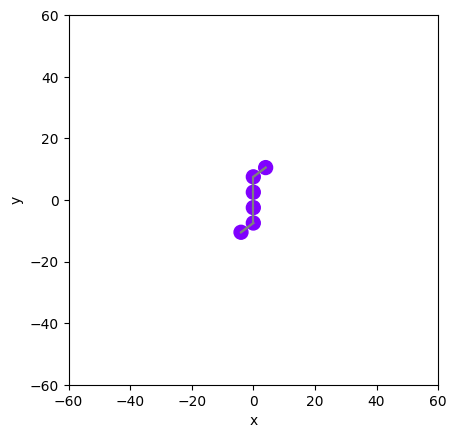

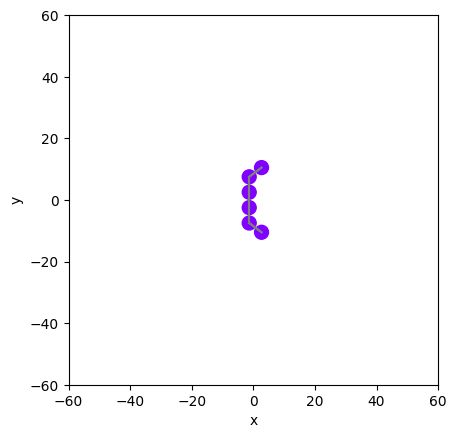

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
k = 4
ntimes = 10

# Create dataset
dataset = create_kchains(k=k)
for data in dataset:
    plot_2d(data, lim=60)

# Create dataloaders
dataloader = loader.DataLoader(dataset, batch_size=1)
val_loader = loader.DataLoader(dataset, batch_size=1)
test_loader = loader.DataLoader(dataset, batch_size=1)
# Set model
model_name = "EGNN"

for num_layers in range(3 , 7):

    correlation = 2
    model = {
        "SchNet": SchNetModel,
        "dimenet": DimeNetPPModel,
        "spherenet": SphereNetModel,
        "EGNN": EGNNModel,
        "GVP": partial(GVPGNNModel, s_dim=32, v_dim=1),
        "TFN": TFNModel,
        "MACE": partial(MACEModel, correlation=correlation),
    }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)

    best_val_acc_list, test_acc_list, train_time_list = run_experiment(
        model,
        dataloader,
        val_loader,
        test_loader,
        n_epochs=150,
        n_times=ntimes,
        device=device,
        verbose=False
    )
    print(f'\nDone! Averaged over {ntimes} runs of {model_name} with {num_layers} layers: \n '
          f'- Training time: {np.mean(train_time_list):.2f}s ± {np.std(train_time_list):.2f}. \n '
          f'- Best validation accuracy: {np.mean(best_val_acc_list):.3f} ± {np.std(best_val_acc_list):.2f}. \n'
          f'- Test accuracy: {np.mean(test_acc_list):.1f} ± {np.std(test_acc_list):.1f}. \n')

# Propogating geometric information: long-dependencies.

In the second set of experiments we test the original $k$-chains for $k$=12. Our aim is to examine long dependences of several models.
For that we run the desired model with increasing number of blocks and report the results.

In [ ]:
k = 12
ntimes = 10

# Create dataset
dataset = create_kchains(k=k)
for data in dataset:
    plot_2d(data, lim=60)

# Create dataloaders
dataloader = loader.DataLoader(dataset, batch_size=1)
val_loader = loader.DataLoader(dataset, batch_size=1)
test_loader = loader.DataLoader(dataset, batch_size=1)
# Set model
model_name = "EGNN"

for num_layers in range(7, 11):

    correlation = 2
    model = {
        "SchNet": SchNetModel,
        "dimenet": DimeNetPPModel,
        "spherenet": SphereNetModel,
        "EGNN": EGNNModel,
        "GVP": partial(GVPGNNModel, s_dim=32, v_dim=1),
        "TFN": TFNModel,
        "MACE": partial(MACEModel, correlation=correlation),
    }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)

    best_val_acc_list, test_acc_list, train_time_list = run_experiment(
        model,
        dataloader,
        val_loader,
        test_loader,
        n_epochs=150,
        n_times=ntimes,
        device=device,
        verbose=False
    )
    print(f'\nDone! Averaged over {ntimes} runs of {model_name} with {num_layers} layers: \n '
          f'- Training time: {np.mean(train_time_list):.2f}s ± {np.std(train_time_list):.2f}. \n '
          f'- Best validation accuracy: {np.mean(best_val_acc_list):.3f} ± {np.std(best_val_acc_list):.2f}. \n'
          f'- Test accuracy: {np.mean(test_acc_list):.1f} ± {np.std(test_acc_list):.1f}. \n')

# Power graph experiments.


# First Pair.
In this section, we show the seperation ability of invariant models depending on the power graph. In this experiment, we show no I-GGNN can sepearte the first power $G^{1}$, but can $G^{2}$.

In [ ]:
ntimes= 10
k = 8

# Create dataset
for power in [1,2]:
  dataset = create_pairA(k=k,power = power)
  print(f"The graph power {power}")
  for data in dataset:
      plot_2d(data, lim=6.0)

  # Create dataloaders
  dataloader = loader.DataLoader(dataset, batch_size=1)
  val_loader = loader.DataLoader(dataset, batch_size=1)
  test_loader = loader.DataLoader(dataset, batch_size=1)
  # Set model
  model_name = "schnet"

  for num_layers in range(5 , 8):

      print(f"\nNumber of layers: {num_layers}")

      correlation = 2
      model = {
          "schnet": SchNetModel,
          "dimenet": DimeNetPPModel,
          "spherenet": SphereNetModel
      }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)

      best_val_acc_list, test_acc_list, train_time_list = run_experiment(
        model,
        dataloader,
        val_loader,
        test_loader,
        n_epochs=150,
        n_times=ntimes,
        device=device,
        verbose=False
    )
      print(f'\nDone! Averaged over {ntimes} runs of {model_name} with {num_layers} layers, power graph {power}: \n '
          f'- Training time: {np.mean(train_time_list):.2f}s ± {np.std(train_time_list):.2f}. \n '
          f'- Best validation accuracy: {np.mean(best_val_acc_list):.3f} ± {np.std(best_val_acc_list):.3f}. \n'
          f'- Test accuracy: {np.mean(test_acc_list):.1f} ± {np.std(test_acc_list):.1f}. \n')

# Second Pair.
In this section, we show the seperation ability of the model depending on the power graph. In this experiment, we show no I-GGNN can sepearte the first power and second but third could be separated.

In [ ]:
ntimes= 10
k = 8

# Create dataset
for power in [1,2,3]:
  dataset = create_pairB(k=k,power = power)
  print(f"The graph power {power}")
  for data in dataset:
      plot_2d(data, lim=6.0)

  # Create dataloaders
  dataloader = loader.DataLoader(dataset, batch_size=1)
  val_loader = loader.DataLoader(dataset, batch_size=1)
  test_loader = loader.DataLoader(dataset, batch_size=1)
  # Set model
  model_name = "schnet"

  for num_layers in range(5 , 7):

      print(f"\nNumber of layers: {num_layers}")

      correlation = 2
      model = {
          "schnet": SchNetModel,
          "dimenet": DimeNetPPModel,
          "spherenet": SphereNetModel
      }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)

      best_val_acc_list, test_acc_list, train_time_list = run_experiment(
        model,
        dataloader,
        val_loader,
        test_loader,
        n_epochs=150,
        n_times=ntimes,
        device=device,
        verbose=False
    )
      print(f'\nDone! Averaged over {ntimes} runs of {model_name} with {num_layers} layers, power graph {power}: \n '
          f'- Training time: {np.mean(train_time_list):.2f}s ± {np.std(train_time_list):.2f}. \n '
          f'- Best validation accuracy: {np.mean(best_val_acc_list):.3f} ± {np.std(best_val_acc_list):.3f}. \n'
          f'- Test accuracy: {np.mean(test_acc_list):.1f} ± {np.std(test_acc_list):.1f}. \n')